# Example 1b: Spin-Bath model (very strong coupling)

### Introduction

The HEOM method solves the dynamics and steady state of a system and its environment, the latter of which is encoded in a set of auxiliary density matrices.

In this example we show the evolution of a single two-level system in contact with a single Bosonic environment.  The properties of the system are encoded in Hamiltonian, and a coupling operator which describes how it is coupled to the environment.

The Bosonic environment is implicitly assumed to obey a particular Hamiltonian (see paper), the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how to model the overdamped Drude-Lorentz Spectral Density, commonly used with the HEOM. We show how to do this using the Matsubara, Pade and fitting decompositions, and compare their convergence.
This notebook shows a similar example to notebook 1a, but with much stronger coupling as discussed in [Shi *et al.*, J. Chem. Phys **130**, 084105 (2009)](https://doi.org/10.1063/1.3077918). Please refer to notebook 1a for a more detailed explanation.

### Drude-Lorentz (overdamped) spectral density
The Drude-Lorentz spectral density is:

$$J_D(\omega)= \frac{2\omega\lambda\gamma}{{\gamma}^2 + \omega^2}$$

where $\lambda$ scales the coupling strength, and $\gamma$ is the cut-off frequency.  We use the convention,
\begin{equation*}
C(t) = \int_0^{\infty} d\omega \frac{J_D(\omega)}{\pi}[\coth(\beta\omega) \cos(\omega \tau) - i \sin(\omega \tau)]
\end{equation*}

With the HEOM we must use an exponential decomposition:

\begin{equation*}
C(t)=\sum_{k=0}^{k=\infty} c_k e^{-\nu_k t}
\end{equation*}

As an example, the Matsubara decomposition of the Drude-Lorentz spectral density is given by:

\begin{equation*}
    \nu_k = \begin{cases}
               \gamma               & k = 0\\
               {2 \pi k} / {\beta }  & k \geq 1\\
           \end{cases}
\end{equation*}

\begin{equation*}
    c_k = \begin{cases}
               \lambda \gamma (\cot(\beta \gamma / 2) - i)             & k = 0\\
               4 \lambda \gamma \nu_k / \{(nu_k^2 - \gamma^2)\beta \}    & k \geq 1\\
           \end{cases}
\end{equation*}

Note that in the above, and the following, we set $\hbar = k_\mathrm{B} = 1$.

In [1]:
import contextlib
import time

import numpy as np
from scipy.optimize import curve_fit
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from qutip import *
from qutip.ipynbtools import HTMLProgressBar
from qutip.nonmarkov.heom import HEOMSolver, BosonicBath, DrudeLorentzBath, DrudeLorentzPadeBath, BathExponent

In [2]:
def cot(x):
    """ Vectorized cotangent of x. """
    return 1. / np.tan(x)

In [3]:
@contextlib.contextmanager
def timer(label):
    """ Simple utility for timing functions:
    
        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

In [4]:
# Defining the system Hamiltonian
eps = .0     # Energy of the 2-level system.
Del = .2     # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del* sigmax()

In [5]:
# Initial state of the system.
rho0 = basis(2,0) * basis(2,0).dag() 

In [6]:
# System-bath coupling (Drude-Lorentz spectral density)
Q = sigmaz() # coupling operator

# Bath properties (see Shi et al., J. Chem. Phys. 130, 084105 (2009)):
gamma = 1. # cut off frequency
lam = 2.5  # coupling strength
T = 1.     # in units where Boltzmann factor is 1
beta = 1./T

#HEOM parameters
NC = 13 # cut off parameter for the bath
Nk = 1  # number of exponents to retain in the Matsubara expansion of the correlation function

# Times to solve for
tlist = np.linspace(0, np.pi/Del, 600)

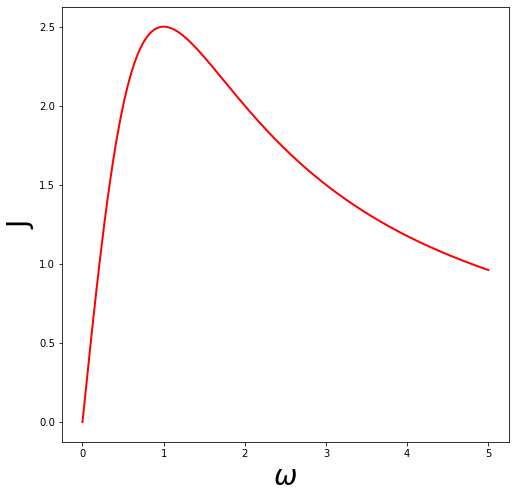

In [7]:
# Plot the spectral density

w = np.linspace(0, 5, 1000)
J = w * 2 * lam * gamma / ((gamma**2 + w**2))

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
axes.plot(w, J, 'r', linewidth=2)
axes.set_xlabel(r'$\omega$', fontsize=28)
axes.set_ylabel(r'J', fontsize=28)
pass

In [8]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p = basis(2, 0) * basis(2, 0).dag()
P22p = basis(2, 1) * basis(2, 1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p = basis(2, 0) * basis(2, 1).dag()

#### Simulation 1: Matsubara decomposition, not using Ishizaki-Tanimura terminator

In [9]:
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

with timer("RHS construction time"):
    bath = DrudeLorentzBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
    HEOMMats = HEOMSolver(Hsys, bath, NC, options=options)

with timer("ODE solver time"):
    resultMats = HEOMMats.run(rho0, tlist)

RHS construction time: 0.02995920181274414
ODE solver time: 0.5069856643676758


#### Simulation 2: Matsubara decomposition (including terminator)

In [10]:
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

with timer("RHS construction time"):
    bath = DrudeLorentzBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
    _, terminator = bath.terminator()
    Ltot = liouvillian(Hsys) + terminator
    HEOMMatsT = HEOMSolver(Ltot, bath, NC, options=options)

with timer("ODE solver time"):
    resultMatsT = HEOMMatsT.run(rho0, tlist)

RHS construction time: 0.034832000732421875
ODE solver time: 0.4625577926635742


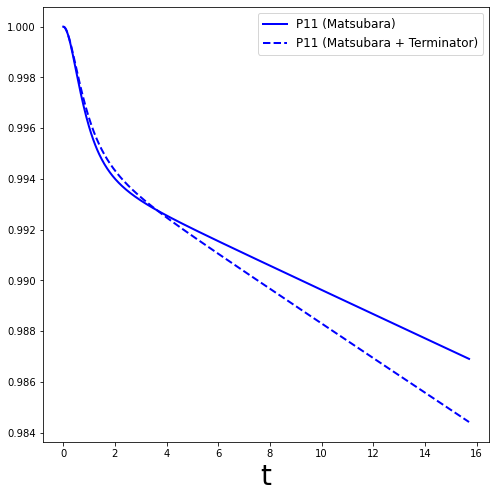

In [11]:
# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))

P11_mats = np.real(expect(resultMats.states, P11p))
axes.plot(tlist, np.real(P11_mats), 'b', linewidth=2, label="P11 (Matsubara)")

P11_matsT = np.real(expect(resultMatsT.states, P11p))
axes.plot(tlist, np.real(P11_matsT), 'b--', linewidth=2, label="P11 (Matsubara + Terminator)")

axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)
pass

#### Simulation 3: Pade decomposition

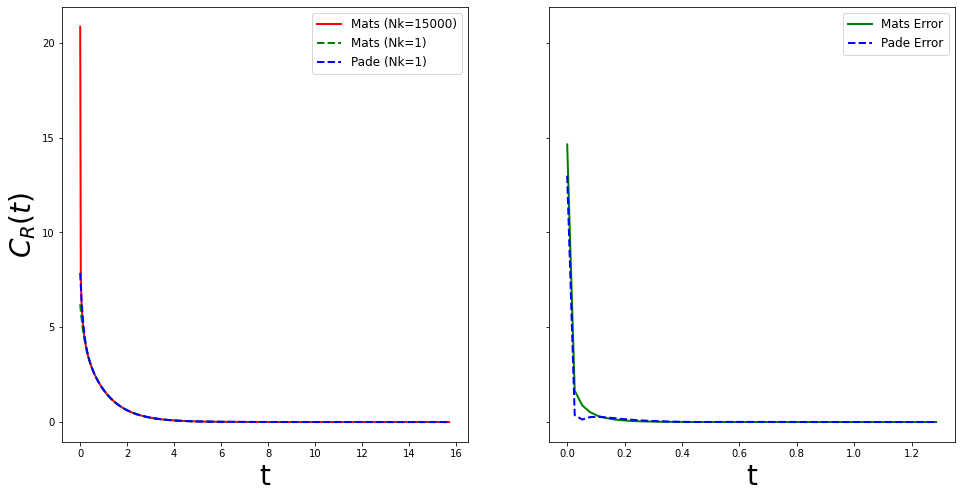

In [12]:
# First, compare Matsubara and Pade decompositions
matsBath = DrudeLorentzBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
padeBath = DrudeLorentzPadeBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)

# We will compare against a summation of {lmaxmats} Matsubara terms
lmaxmats = 15000
exactBath = DrudeLorentzBath(Q, lam=lam, gamma=gamma, T=T, Nk=lmaxmats, combine=False)

# Real and imag. parts of the correlation functions:
def CR(bath, t):
    result = 0
    for exp in bath.exponents:
        if exp.type == BathExponent.types['R'] or exp.type == BathExponent.types['RI']:
            result += exp.ck * np.exp(-exp.vk * t)
    return result

def CI(bath, t):
    result = 0
    for exp in bath.exponents:
        if exp.type == BathExponent.types['I']:
            result += exp.ck * np.exp(exp.vk * t)
        if exp.type == BathExponent.types['RI']:
            result += exp.ck2 * np.exp(exp.vk * t)
    return result

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(16, 8))

ax1.plot(tlist, CR(exactBath, tlist), "r", linewidth=2, label=f"Mats (Nk={lmaxmats})")
ax1.plot(tlist, CR(matsBath, tlist), "g--", linewidth=2, label=f"Mats (Nk={Nk})")
ax1.plot(tlist, CR(padeBath, tlist), "b--", linewidth=2, label=f"Pade (Nk={Nk})")

ax1.set_xlabel(r't', fontsize=28)
ax1.set_ylabel(r"$C_R(t)$", fontsize=28)
ax1.legend(loc=0, fontsize=12)

tlist2=tlist[0:50]
ax2.plot(tlist2, np.abs(CR(matsBath, tlist2) - CR(exactBath, tlist2)), "g", linewidth=2, label=f"Mats Error")
ax2.plot(tlist2, np.abs(CR(padeBath, tlist2) - CR(exactBath, tlist2)), "b--", linewidth=2, label=f"Pade Error")

ax2.set_xlabel(r't', fontsize=28)
ax2.legend(loc=0, fontsize=12)
pass

In [13]:
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

with timer("RHS construction time"):
    bath = DrudeLorentzPadeBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
    HEOMPade = HEOMSolver(Hsys, bath, NC, options=options)

with timer("ODE solver time"):
    resultPade = HEOMPade.run(rho0, tlist)

RHS construction time: 0.030994892120361328
ODE solver time: 0.4531726837158203


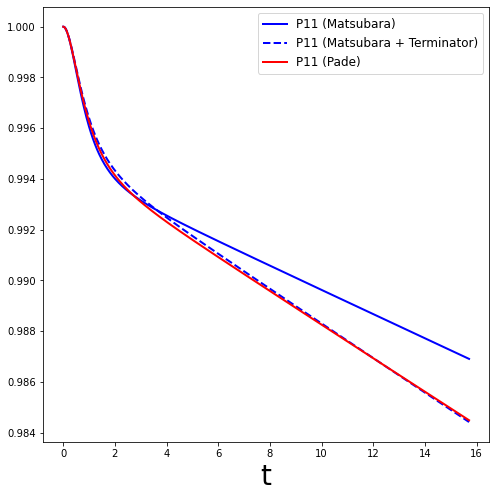

In [14]:
# Plot the results
fig, axes = plt.subplots(figsize=(8,8))

axes.plot(tlist, np.real(P11_mats), 'b', linewidth=2, label="P11 (Matsubara)")
axes.plot(tlist, np.real(P11_matsT), 'b--', linewidth=2, label="P11 (Matsubara + Terminator)")

P11_pade = np.real(expect(resultPade.states, P11p))
axes.plot(tlist, np.real(P11_pade), 'r', linewidth=2, label="P11 (Pade)")

axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)
pass

#### Simulation 4: Fitting approach

In [15]:
# Fitting data
tlist_fit = np.linspace(0, 6, 10000)
corrRana = CR(exactBath, tlist_fit)

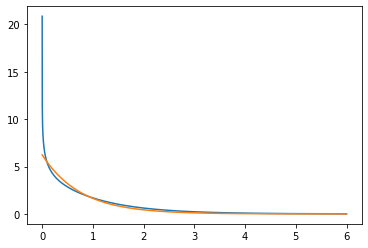

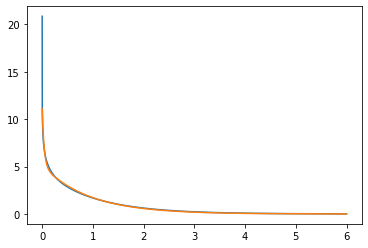

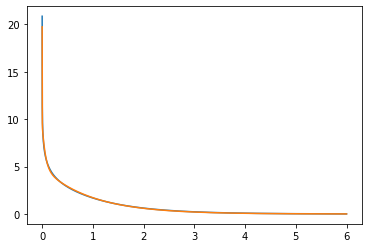

In [16]:
# Fitting procedure

def wrapper_fit_func(x, N, *args):
    a, b = list(args[0][:N]), list(args[0][N:2*N])
    return fit_func(x, a, b, N)

# actual fitting function
def fit_func(x, a, b, N):
    tot = 0
    for i in range(N):
        tot += a[i]*np.exp(b[i]*x)
    return tot


def fitter(ans, tlist, k):
    # the actual computing of fit
    popt = []
    pcov = [] 
    # tries to fit for k exponents
    for i in range(k):
        params_0 = [0]*(2*(i+1))
        upper_a = abs(max(ans, key = abs))*10
        #sets initial guess
        guess = []
        aguess = [ans[0]]*(i+1)#[max(ans)]*(i+1)
        bguess = [0]*(i+1)
        guess.extend(aguess)
        guess.extend(bguess)
        # sets bounds
        # a's = anything , b's negative
        # sets lower bound
        b_lower = []
        alower = [-upper_a]*(i+1)
        blower = [-np.inf]*(i+1)
        b_lower.extend(alower)
        b_lower.extend(blower)
        # sets higher bound
        b_higher = []
        ahigher = [upper_a]*(i+1)
        bhigher = [0]*(i+1)
        b_higher.extend(ahigher)
        b_higher.extend(bhigher)
        param_bounds = (b_lower, b_higher)
        p1, p2 = curve_fit(lambda x, *params_0: wrapper_fit_func(x, i+1, params_0),
                           tlist, ans, p0=guess, sigma=([0.01] * len(tlist)),
                           bounds = param_bounds, maxfev = 1e8)
        popt.append(p1)
        pcov.append(p2)
    return popt

# function that evaluates values with fitted params at given inputs
def checker(tlist, vals):
    y = []
    for i in tlist:
        y.append(wrapper_fit_func(i, int(len(vals)/2), vals))
    return y

# Fits of the real part with up to 3 exponents
k = 3
popt1 = fitter(corrRana, tlist_fit, k)
for i in range(k):
    y = checker(tlist_fit, popt1[i])
    plt.plot(tlist_fit, corrRana, tlist_fit, y)
    plt.show()

In [17]:
# Set the exponential coefficients from the fit parameters

ckAR1 = list(popt1[k-1])[:len(list(popt1[k-1]))//2]
ckAR = [complex(x) for x in ckAR1]

vkAR1 = list(popt1[k-1])[len(list(popt1[k-1]))//2:]
vkAR = [complex(-x) for x in vkAR1]

# Imaginary part: use analytical value
ckAI = [complex(lam * gamma * (-1.0))]
vkAI = [complex(gamma)]

In [18]:
options = Options(nsteps=1500, store_states=True, rtol=1e-12, atol=1e-12)

with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)
    HEOMFit = HEOMSolver(Hsys, bath, NC, options=options)
    
with timer("ODE solver time"):
    resultFit = HEOMFit.run(rho0, tlist)

RHS construction time: 0.5574820041656494
ODE solver time: 162.1322946548462


#### Simulation 5: Bloch-Redfield

In [19]:
DL = ("2 * pi * 2.0 * {lam} / (pi * {gamma} * {beta}) if (w==0) "
      "else 2 * pi * (2.0 * {lam} * {gamma} * w / (pi * (w**2 + {gamma}**2))) "
      "* ((1 / (exp(w * {beta}) - 1)) + 1)").format(gamma=gamma, beta=beta, lam=lam)

options = Options(nsteps=15000, store_states=True, rtol=1e-12, atol=1e-12)
resultBR = brmesolve(Hsys, rho0, tlist, a_ops=[[sigmaz(), DL]], options=options)

In [20]:
qsave(resultMats, 'data/resultMatsOD')
qsave(resultMatsT, 'data/resultMatsTOD')
qsave(resultPade, 'data/resultPadeOD')
qsave(resultFit, 'data/resultFitOD')
qsave(resultBR, 'data/resultBROD')

### Create Plot

In [21]:
with contextlib.redirect_stdout(None):
    resultMats = qload('data/resultMatsOD')
    resultMatsT = qload('data/resultMatsTOD')
    resultPade = qload('data/resultPadeOD')
    resultFit = qload('data/resultFitOD')
    resultBR = qload('data/resultBROD')

In [22]:
matplotlib.rcParams['figure.figsize'] = (7, 5)
matplotlib.rcParams['axes.titlesize'] = 25
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['xtick.labelsize'] = 28
matplotlib.rcParams['ytick.labelsize'] = 28
matplotlib.rcParams['legend.fontsize'] = 28
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['lines.markersize'] = 5
matplotlib.rcParams['font.family'] = 'STIXgeneral' 
matplotlib.rcParams['mathtext.fontset'] =  'stix'
matplotlib.rcParams["font.serif"] = "STIX"
matplotlib.rcParams['text.usetex'] = False

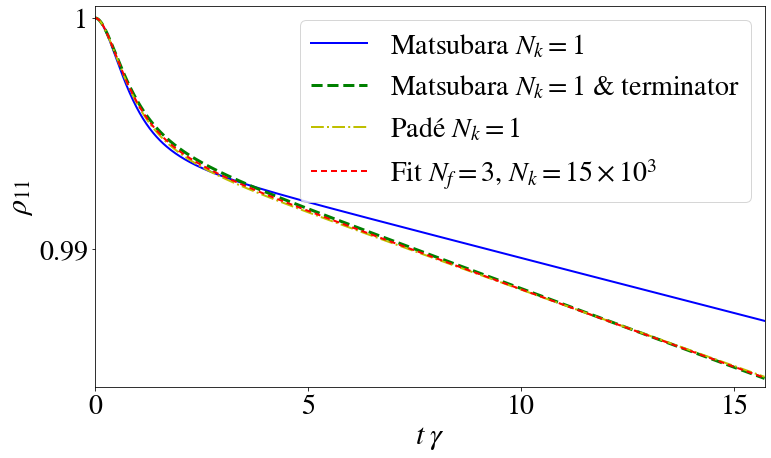

In [23]:
# Calculate expectation values in the bases
P11_mats = np.real(expect(resultMats.states, P11p))
P11_matsT = np.real(expect(resultMatsT.states, P11p))
P11_pade = np.real(expect(resultPade.states, P11p))
P11_fit = np.real(expect(resultFit.states, P11p))
P11_br = np.real(expect(resultBR.states, P11p))

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12,7))
plt.yticks([0.99,1.0],[0.99,1])
axes.plot(tlist, np.real(P11_mats), 'b', linewidth=2, label=r"Matsubara $N_k=%d$" % Nk)
axes.plot(tlist, np.real(P11_matsT), 'g--', linewidth=3, label=r"Matsubara $N_k=%d$ & terminator" % Nk)
axes.plot(tlist, np.real(P11_pade), 'y-.', linewidth=2, label=r"Padé $N_k=%d$" % Nk)
# axes.plot(tlist, np.real(P11_br), 'y-.', linewidth=10, label="Bloch Redfield")
axes.plot(tlist, np.real(P11_fit), 'r',dashes=[3,2], linewidth=2, label=r"Fit $N_f = 3$, $N_k=15 \times 10^3$")

axes.locator_params(axis='y', nbins=6)
axes.locator_params(axis='x', nbins=6)
axes.set_ylabel(r'$\rho_{11}$',fontsize=30)

axes.set_xlabel(r'$t\;\gamma$',fontsize=30)
axes.set_xlim(tlist[0],tlist[-1])
axes.set_ylim(0.98405,1.0005)
axes.legend(loc=0)

#fig.savefig("figures/fig2.pdf")
pass

In [24]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.7.0.dev0+b71625e
Numpy,1.21.2
SciPy,1.7.1
matplotlib,3.5.0
Cython,0.29.25
Number of CPUs,6
BLAS Info,INTEL MKL
IPython,7.29.0
Python,"3.9.7 (default, Sep 16 2021, 13:09:58) [GCC 7.5.0]"
OS,posix [linux]
